In [1]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [2]:
mat_data = loadmat('ex3data1.mat')

In [3]:
print(mat_data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])


In [4]:
mat_data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'y': array([[10],
        [10],
        [10],
        ...,
        [ 9],
        [ 9],
        [ 9]], dtype=uint8)}

In [5]:
X_origin = mat_data['X']
X = np.insert(X_origin,0,np.ones(X_origin.shape[0]),axis=1)
y = mat_data['y']
X.shape,y.shape

((5000, 401), (5000, 1))

(100, 400)


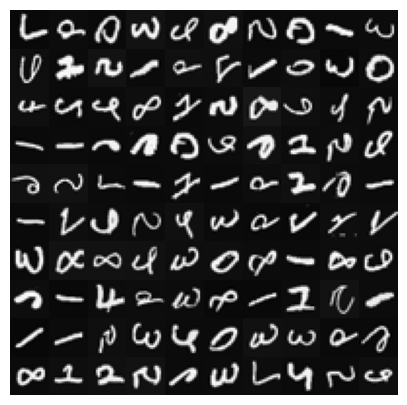

In [6]:
sample_indices = np.random.randint(0, len(X), 100)
samples = X_origin[sample_indices,:]
print(samples.shape)
fig, axes = plt.subplots(10, 10, figsize=(5, 5), gridspec_kw={'wspace': 0, 'hspace': 0})
for i, ax in enumerate(axes.flat):
    imgdata = samples[i,:].reshape(20,20)
    ax.imshow(imgdata, cmap='gray')  # 使用灰度色彩映射显示
    ax.axis('off')
plt.show()

In [7]:
def sigmoid(x):
    return 1/(1+np.exp(-x))
def cost(theta,X,y):
    theta = theta.reshape(-1, 1)
    m = len(X)
    cost = (-y.T @ np.log(sigmoid(X @ theta))-(1-y).T@np.log(1-sigmoid(X@theta)))/m
    return cost[0,0]
def gradient(theta,X,y):
    theta = theta.reshape(-1, 1)
    m = len(X)
    gradient = X.T@(sigmoid(X@theta)-y)/m
    return gradient.ravel()
def reCost(theta,X,y,lamda):
    m = len(y)
    theta = theta.reshape(-1,1)
    noRe_cost = cost(theta,X,y)
    re = np.sum(theta[1:,:]**2)*lamda/(2*m)
    reCost = noRe_cost+re
    return reCost
def reGradient(theta,X,y,lamda):
    theta = theta.ravel()
    noRe_gradient = gradient(theta,X,y)
    re = lamda/len(y)*theta
    reGradient = noRe_gradient + re
    reGradient[0] =  noRe_gradient[0]
    return reGradient

# 获得分类器

In [8]:
def one_vs_all(X,y,lamda = 0,theta = None):
    print(lamda)
    # 获得y的标签信息，有哪些镖旗，数量是多少，决定我们做几个分类
    labels = np.unique(y)
    labelsCnt = labels.shape[0]
    # 需要分几个类，就需要多少组theta
    if theta == None:
        theta = np.zeros((labelsCnt,X.shape[1]))
    for i in range(labelsCnt):
        # 将所有类别的标签都变为0,1分类器，True->1；False->0
        yi = (y == labels[i]).astype(int)
        # 利用优化器得到最优结果
        result = minimize(fun = reCost,x0=theta[i],args=(X,yi,lamda),jac= reGradient,method='TNC')
        # result = minimize(fun = cost,x0=theta[i],args=(X,yi),jac = gradient,method='TNC')
        # 将获得theta值保存下来
        theta[i] = result.x
    return theta

注意，theta是一维数组，因此当它被转换为计算梯度的代码中的矩阵时，它变为（1×401）矩阵。 我们还检查y中的类标签，以确保它们看起来像我们想象的一致。

In [9]:
X.shape,y.shape

((5000, 401), (5000, 1))

In [10]:
theta = one_vs_all(X,y,lamda=1)
theta

1


array([[-2.38161322e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.30443875e-03, -7.46614921e-10,  0.00000000e+00],
       [-3.18424598e+00,  0.00000000e+00,  0.00000000e+00, ...,
         4.45809777e-03, -5.08268007e-04,  0.00000000e+00],
       [-4.79683980e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -2.87602778e-05, -2.47281993e-07,  0.00000000e+00],
       ...,
       [-7.98707330e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -8.94820479e-05,  7.21528197e-06,  0.00000000e+00],
       [-4.57330391e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.33547404e-03,  9.98705604e-05,  0.00000000e+00],
       [-5.40445967e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.16377778e-04,  7.87930109e-06,  0.00000000e+00]])

In [11]:
def predict_accRate(theta,X,y):
    # 算出每个样本的h值(sigmoid)，由于一共有10个分类器，每个样本则有10个分类对应的可能值，
    # h_values_predict,每一行代表一个样本的各类评分，第0列是1类评分，第二列是2类评分，以此类推
    h_values_predict = sigmoid(X@theta.T)
    print(f'h_values_predict:\n{h_values_predict}\n\n\n')
    # 每一行中，找出最大值的索引，这个索引刚好和分类符号差1.加上1，就得到了每一行最可能的类别
    ylabels_predict = h_values_predict.argmax(1)+1
    print(f'ylabels_predict:\n{ylabels_predict}\n\n')
    # 与给定的y做比较，正确的元素数量/总数量就是准确率
    acc_predict = (ylabels_predict == y.ravel()).astype(int)
    print(f'acc_predict:\n{acc_predict}\n\n')

    accRate = np.sum(acc_predict)/len(y)
    return accRate

In [12]:
predict_accRate(theta,X,y)

h_values_predict:
[[2.39696671e-09 5.35140787e-04 1.19630710e-04 ... 3.91197223e-05
  1.71993703e-03 9.95777514e-01]
 [9.75455609e-08 5.60439210e-05 2.22509309e-04 ... 2.90427606e-06
  8.48545848e-05 9.98346652e-01]
 [2.59086257e-10 5.68596772e-04 1.40546177e-03 ... 2.65346835e-02
  1.97340097e-03 9.91398892e-01]
 ...
 [4.13294749e-02 3.20832665e-03 7.65078695e-02 ... 2.97391343e-03
  7.07610280e-01 6.77960600e-07]
 [1.31869971e-07 8.88011318e-08 8.32879103e-06 ... 6.81478160e-02
  8.61138881e-01 1.84153732e-05]
 [1.50239535e-10 1.29769494e-04 4.19924506e-08 ... 4.97494064e-03
  1.48205443e-01 2.88020329e-02]]



ylabels_predict:
[10 10 10 ...  9  9  7]


acc_predict:
[1 1 1 ... 1 1 0]




0.9446